In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import igraph as ig
import leidenalg as la
from collections import Counter
import networkx as nx
import polars as pl

In [3]:
from sklearn.metrics import adjusted_rand_score, rand_score,normalized_mutual_info_score
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans,MeanShift, estimate_bandwidth , Birch

In [4]:
df = pl.read_csv("reddit-users.csv")
df

rotoreuters,-0.224305,0.034301,-0.082651,0.004676,0.00696,0.892179,-0.309423,0.570185,0.49211,0.667661,0.379927,-0.701833,0.494844,-0.112651,-0.499859,-0.03113,-0.17902,-0.307026,0.804202,-0.126007,0.298278,0.699318,-0.122089,-0.147698,0.347853,-0.171306,-0.324271,-0.599804,0.423248,-0.56949,-0.824675,-0.568197,-0.515359,-0.281378,-0.631208,0.31375,…,-0.337365,-0.418125,-0.084188,-0.248032,0.35677,0.028407,-0.21356,0.06294,-0.188042,0.431441,-0.472865,0.222936,0.076625,0.285511,0.222161,0.284596,-0.158964,0.182507,0.711164,0.423767,-0.486449,0.403645,-0.716357,-0.359746,0.063134,0.646768,-0.287045,-0.380348,-0.14416,-0.289317,0.471727,-0.174092,0.534364,0.218821,0.269216,-0.412621,-0.469088
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""fiplefip""",-0.306765,0.259314,-0.950335,0.560013,-0.364981,0.073359,-0.256642,-0.348088,-0.030323,-0.284338,0.377343,-0.358473,0.559322,0.062051,0.099554,0.46136,-0.273855,-0.274918,0.725871,-0.230823,-0.436114,0.186223,-0.004017,0.297142,-0.066631,0.16217,-0.364509,0.229731,-0.151828,0.22865,0.171403,-0.334804,-0.408777,-0.165566,0.274575,-0.265074,…,-0.007571,-0.811709,0.228903,-0.525756,0.513215,-0.197298,-0.706438,-0.42467,0.410469,0.16759,0.003496,0.130472,-0.59432,-0.076453,0.671613,-0.53084,0.171624,-0.14149,0.264164,-0.338885,-0.125357,-0.206496,0.660746,-0.327274,0.188642,0.439133,-0.158999,-0.432182,-0.769793,-0.434484,0.268733,-0.163076,-0.455654,0.41656,-0.219805,-0.568944,-0.477788
"""amici_ursi""",-0.234556,0.60916,-0.065395,-0.212264,0.269761,-0.562834,-0.455435,-0.349673,0.391979,0.36878,-0.332526,-0.612227,0.881066,-0.310739,0.338838,-0.069625,-0.223117,0.319171,0.984606,0.245857,0.85169,-0.294353,0.134919,-0.026722,0.360474,0.187247,-0.023172,0.356334,-0.13018,-0.085904,-0.098366,0.615505,0.404617,0.230763,-0.305228,0.863486,…,-0.144152,-0.504473,-0.384659,-0.827701,0.187106,-0.053623,-0.003742,-0.774822,0.251569,-0.868102,-0.863559,-0.002648,0.084968,0.187232,-0.172234,0.728021,-0.188714,0.579466,-0.209696,0.877766,-0.14669,-0.592308,-0.037788,-0.548592,0.301136,0.873749,0.233379,0.622636,0.23427,0.083597,-0.647548,0.103007,0.344196,0.140004,0.579194,-0.046483,-0.705478
"""unremovable""",0.253033,0.548086,-0.538728,0.375164,-0.129068,0.307664,-0.047697,-0.492977,0.224615,0.073754,-0.286705,0.011221,0.601635,-0.535227,-0.487574,-0.058265,-0.224699,0.003262,0.889734,-0.533337,-0.315974,0.377092,0.833714,-0.320869,0.634363,0.197973,0.561948,0.049643,0.112593,0.308731,-0.208679,0.16751,0.39875,0.018139,0.002018,0.76555,…,-0.180951,0.170767,-0.143426,-0.521084,-0.232333,0.294799,-0.117459,0.053756,0.421318,0.052284,-0.262025,0.164859,-0.848743,0.55363,0.349082,-0.135026,0.635478,-0.2771,0.335012,0.315789,0.046486,0.604992,-0.487021,-0.582454,-0.287221,0.907134,-0.38617,0.165165,-0.21692,-0.414641,-0.144242,0.18506,0.356242,0.095848,0.40301,-0.320782,-0.735368
"""CDRE_64""",-0.008056,0.05056,-0.295054,-0.046483,0.04242,0.345231,0.075705,-0.198281,0.139585,0.174352,0.134547,-0.214878,0.495939,-0.149515,-0.077004,0.404769,-0.250609,-0.405186,0.347727,-0.11806,0.313708,-0.187699,0.101371,-0.073235,0.188572,0.095709,-0.108428,0.193696,-0.135239,-0.310914,-0.224337,0.133148,-0.112955,-0.063444,-0.525183,0.218605,…,-0.270214,-0.122056,-0.028533,-0.358274,0.002222,-0.025049,-0.344229,-0.11333,0.094965,-0.26357,-0.364839,-0.003944,-0.093974,-0.101392,0.161158,0.124243,-0.125217,-0.032501,0.328473,0.337958,-0.156932,0.002218,-0.24986,-0.15847,0.123921,0.427048,-0.048551,-0.221219,-0.474621,-0.149465,-0.156034,-0.115828,-0.170805,0.284541,-0.14477,-0.05001,-0.341634
"""noeatnosleep""",0.313406,0.702873,0.076761,-0.511176,0.374304,-0.247656,0.148855,-0.616189,-0.144205,0.222953,-0.183565,-0.363646,0.869296,-0.146551,0.176667,-0.178732,0.01879

In [5]:
usernames = df["rotoreuters"].to_list()
X = df.drop("rotoreuters")
X

-0.224305,0.034301,-0.082651,0.004676,0.00696,0.892179,-0.309423,0.570185,0.49211,0.667661,0.379927,-0.701833,0.494844,-0.112651,-0.499859,-0.03113,-0.17902,-0.307026,0.804202,-0.126007,0.298278,0.699318,-0.122089,-0.147698,0.347853,-0.171306,-0.324271,-0.599804,0.423248,-0.56949,-0.824675,-0.568197,-0.515359,-0.281378,-0.631208,0.31375,0.43415,…,-0.337365,-0.418125,-0.084188,-0.248032,0.35677,0.028407,-0.21356,0.06294,-0.188042,0.431441,-0.472865,0.222936,0.076625,0.285511,0.222161,0.284596,-0.158964,0.182507,0.711164,0.423767,-0.486449,0.403645,-0.716357,-0.359746,0.063134,0.646768,-0.287045,-0.380348,-0.14416,-0.289317,0.471727,-0.174092,0.534364,0.218821,0.269216,-0.412621,-0.469088
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.306765,0.259314,-0.950335,0.560013,-0.364981,0.073359,-0.256642,-0.348088,-0.030323,-0.284338,0.377343,-0.358473,0.559322,0.062051,0.099554,0.46136,-0.273855,-0.274918,0.725871,-0.230823,-0.436114,0.186223,-0.004017,0.297142,-0.066631,0.16217,-0.364509,0.229731,-0.151828,0.22865,0.171403,-0.334804,-0.408777,-0.165566,0.274575,-0.265074,0.429774,…,-0.007571,-0.811709,0.228903,-0.525756,0.513215,-0.197298,-0.706438,-0.42467,0.410469,0.16759,0.003496,0.130472,-0.59432,-0.076453,0.671613,-0.53084,0.171624,-0.14149,0.264164,-0.338885,-0.125357,-0.206496,0.660746,-0.327274,0.188642,0.439133,-0.158999,-0.432182,-0.769793,-0.434484,0.268733,-0.163076,-0.455654,0.41656,-0.219805,-0.568944,-0.477788
-0.234556,0.60916,-0.065395,-0.212264,0.269761,-0.562834,-0.455435,-0.349673,0.391979,0.36878,-0.332526,-0.612227,0.881066,-0.310739,0.338838,-0.069625,-0.223117,0.319171,0.984606,0.245857,0.85169,-0.294353,0.134919,-0.026722,0.360474,0.187247,-0.023172,0.356334,-0.13018,-0.085904,-0.098366,0.615505,0.404617,0.230763,-0.305228,0.863486,0.072753,…,-0.144152,-0.504473,-0.384659,-0.827701,0.187106,-0.053623,-0.003742,-0.774822,0.251569,-0.868102,-0.863559,-0.002648,0.084968,0.187232,-0.172234,0.728021,-0.188714,0.579466,-0.209696,0.877766,-0.14669,-0.592308,-0.037788,-0.548592,0.301136,0.873749,0.233379,0.622636,0.23427,0.083597,-0.647548,0.103007,0.344196,0.140004,0.579194,-0.046483,-0.705478
0.253033,0.548086,-0.538728,0.375164,-0.129068,0.307664,-0.047697,-0.492977,0.224615,0.073754,-0.286705,0.011221,0.601635,-0.535227,-0.487574,-0.058265,-0.224699,0.003262,0.889734,-0.533337,-0.315974,0.377092,0.833714,-0.320869,0.634363,0.197973,0.561948,0.049643,0.112593,0.308731,-0.208679,0.16751,0.39875,0.018139,0.002018,0.76555,0.261157,…,-0.180951,0.170767,-0.143426,-0.521084,-0.232333,0.294799,-0.117459,0.053756,0.421318,0.052284,-0.262025,0.164859,-0.848743,0.55363,0.349082,-0.135026,0.635478,-0.2771,0.335012,0.315789,0.046486,0.604992,-0.487021,-0.582454,-0.287221,0.907134,-0.38617,0.165165,-0.21692,-0.414641,-0.144242,0.18506,0.356242,0.095848,0.40301,-0.320782,-0.735368
-0.008056,0.05056,-0.295054,-0.046483,0.04242,0.345231,0.075705,-0.198281,0.139585,0.174352,0.134547,-0.214878,0.495939,-0.149515,-0.077004,0.404769,-0.250609,-0.405186,0.347727,-0.11806,0.313708,-0.187699,0.101371,-0.073235,0.188572,0.095709,-0.108428,0.193696,-0.135239,-0.310914,-0.224337,0.133148,-0.112955,-0.063444,-0.525183,0.218605,0.149472,…,-0.270214,-0.122056,-0.028533,-0.358274,0.002222,-0.025049,-0.344229,-0.11333,0.094965,-0.26357,-0.364839,-0.003944,-0.093974,-0.101392,0.161158,0.124243,-0.125217,-0.032501,0.328473,0.337958,-0.156932,0.002218,-0.24986,-0.15847,0.123921,0.427048,-0.048551,-0.221219,-0.474621,-0.149465,-0.156034,-0.115828,-0.170805,0.284541,-0.14477,-0.05001,-0.341634
0.313406,0.702873,0.076761,-0.511176,0.374304,-0.247656,0.148855,-0.616189,-0.144205,0.222953,-0.183565,-0.363646,0.869296,-0.146551,0.176667,-0.178732,0.018797,-0.18148,1.014249,-0.096242,0.79333,0.656905,-0.1

In [6]:
from scipy.sparse import csr_matrix

In [7]:
k = 20

nbrs = NearestNeighbors(n_neighbors=k, metric='cosine').fit(X)
distances, indices = nbrs.kneighbors(X)

In [8]:
rows = np.repeat(np.arange(len(X)), k)
cols = indices.flatten()
vals = 1 - distances.flatten()        # تبدیل distance → similarity

A = sp.csr_matrix((vals, (rows, cols)), shape=(len(X), len(X)))
A

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2367600 stored elements and shape (118380, 118380)>

In [9]:
print("نوع داده:", type(A))
print("شکل ماتریس:", A.shape)
print("تعداد عناصر غیر صفر:", A.nnz)
print("تراکم (density):", A.nnz / (A.shape[0] * A.shape[1]))

نوع داده: <class 'scipy.sparse._csr.csr_matrix'>
شکل ماتریس: (118380, 118380)
تعداد عناصر غیر صفر: 2367600
تراکم (density): 0.00016894745734076703


#### ماتریس رو متقارن میکنیم 

In [10]:
symmetric_matrix = A.maximum(A.T)
symmetric_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4416036 stored elements and shape (118380, 118380)>

In [11]:
print("نوع داده:", type(symmetric_matrix))
print("شکل ماتریس:", symmetric_matrix.shape)
print("تعداد عناصر غیر صفر:", symmetric_matrix.nnz)
print("تراکم (density):", symmetric_matrix.nnz / (symmetric_matrix.shape[0] * symmetric_matrix.shape[1]))

نوع داده: <class 'scipy.sparse._csr.csr_matrix'>
شکل ماتریس: (118380, 118380)
تعداد عناصر غیر صفر: 4416036
تراکم (density): 0.0003151199753865904


In [12]:
# اندیس‌های عناصر غیرصفری ماتریس اسپارس A را برمی‌گرداند.
records, fields = A.nonzero()
#مقادیر غیرصفری ماتریس A را برمی‌گرداند.
weights = A.data


#ساخت گراف igraph از ماتریس
g = ig.Graph(n=A.shape[0], edges=list(zip(records, fields)))

# ویژگی وزن هر یال را برای مجموعه یال‌های گراف تنظیم می‌کند.
g.es["weight"] = weights

# اجرای leiden
partition = la.find_partition(g, la.RBConfigurationVertexPartition, weights="weight")
partition

In [13]:
print(partition)

Clustering with 118380 elements and 38 clusters
[ 0] 17, 40, 141, 168, 220, 244, 286, 363, 397, 560, 614, 645, 662, 711, 726,
     736, 756, 784, 870, 894, 1004, 1021, 1038, 1048, 1077, 1090, 1123, 1124,
     1139, 1142, 1198, 1212, 1237, 1245, 1249, 1345, 1412, 1451, 1469, 1470,
     1478, 1513, 1567, 1572, 1627, 1657, 1729, 1747, 1808, 1900, 1969, 1987,
     2034, 2040, 2095, 2110, 2176, 2177, 2251, 2276, 2291, 2307, 2319, 2324,
     2330, 2340, 2393, 2404, 2418, 2447, 2456, 2459, 2543, 2546, 2549, 2566,
     2574, 2583, 2593, 2594, 2607, 2657, 2705, 2706, 2759, 2768, 2769, 2776,
     2777, 2784, 2833, 2864, 2874, 2940, 2986, 2996, 2998, 2999, 3004, 3021,
     3022, 3064, 3091, 3125, 3165, 3188, 3198, 3203, 3225, 3249, 3268, 3276,
     3294, 3310, 3388, 3422, 3423, 3431, 3454, 3481, 3499, 3509, 3567, 3597,
     3624, 3628, 3651, 3665, 3674, 3677, 3697, 3742, 3760, 3792, 3800, 3802,
     3803, 3823, 3826, 3836, 3871, 3878, 3890, 3909, 3951, 3952, 3961, 3970,
     4020, 4061, 4073, 408

In [14]:
import matplotlib.pyplot as plt

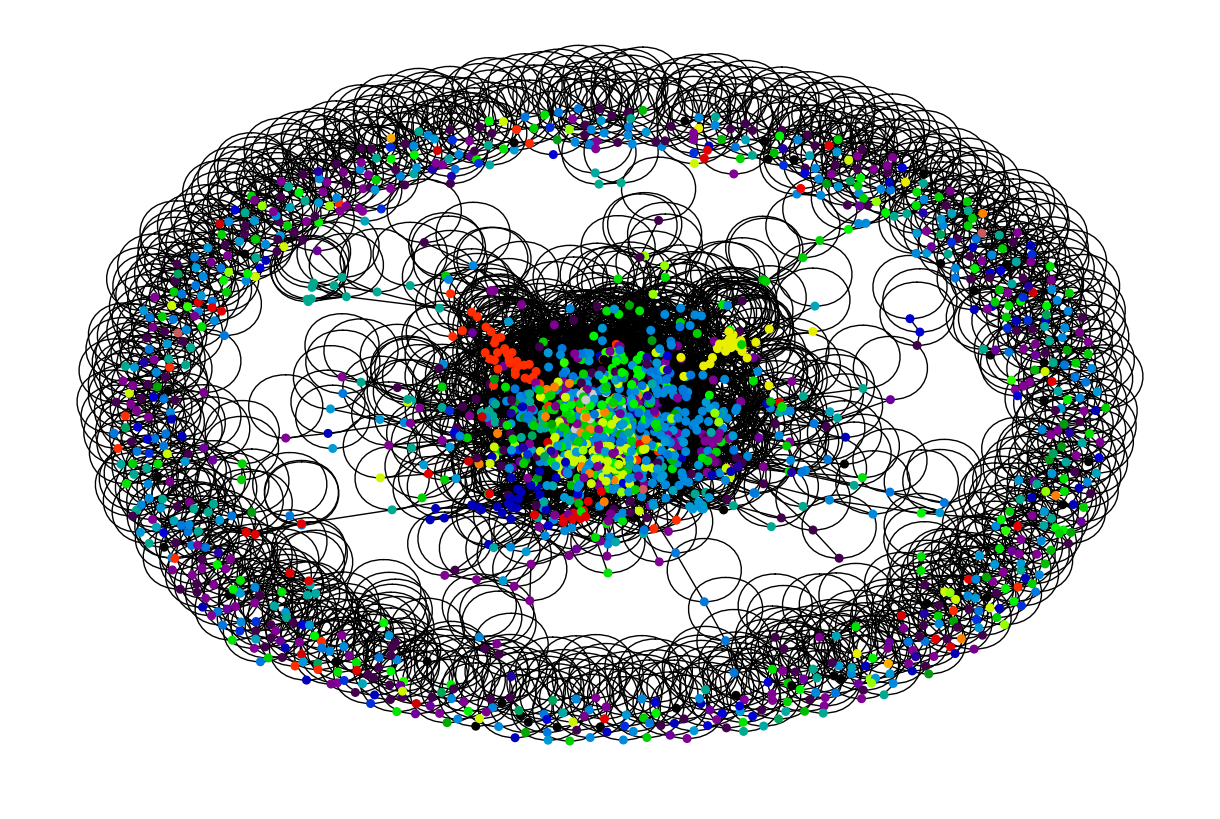

In [15]:
# انتخاب زیرگراف از igraph
sample = list(range(2000))
H = g.subgraph(sample)

# تبدیل به networkx
H_nx = nx.Graph()
H_nx.add_nodes_from(range(H.vcount()))
H_nx.add_edges_from(H.get_edgelist())

# گرفتن لیبل اجتماع هر رأس از partition
membership = partition.membership

# رنگ‌دهی بر اساس شماره کلاستر
colors = [membership[v] for v in H.vs.indices[:H.vcount()]]

plt.figure(figsize=(12, 8))
nx.draw(
    H_nx,
    with_labels=False,
    node_size=30,
    node_color=colors,
    cmap=plt.cm.nipy_spectral   # پالت بزرگ برای ۳۸ کلاستر
)
plt.show()

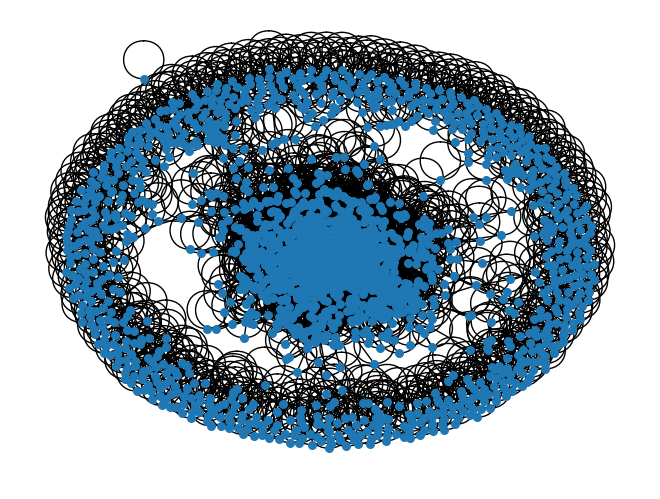

In [16]:
sample = list(range(2000))
H = g.subgraph(sample)

# تبدیل igraph به networkx
H_nx = H.to_networkx()

nx.draw(H_nx, with_labels=False, node_size=30)

In [17]:
from networkx.algorithms.community.quality import modularity

In [18]:
labels_pred = partition.membership
print(labels_pred)

[19, 24, 19, 24, 24, 10, 19, 31, 24, 10, 6, 3, 7, 36, 14, 24, 24, 0, 15, 19, 21, 4, 30, 10, 10, 30, 10, 32, 9, 10, 2, 22, 14, 10, 24, 19, 1, 21, 19, 14, 0, 10, 19, 20, 19, 32, 10, 24, 14, 29, 3, 10, 14, 19, 10, 13, 10, 1, 10, 21, 10, 24, 11, 3, 9, 21, 3, 14, 10, 6, 19, 19, 11, 10, 11, 24, 10, 24, 10, 30, 10, 10, 10, 10, 3, 10, 19, 1, 10, 14, 24, 1, 24, 14, 30, 32, 30, 4, 10, 24, 11, 19, 10, 22, 10, 10, 10, 30, 19, 24, 19, 21, 10, 2, 24, 19, 30, 20, 6, 29, 10, 1, 14, 10, 3, 14, 24, 11, 30, 24, 14, 10, 19, 11, 12, 6, 21, 24, 1, 10, 3, 0, 20, 2, 19, 1, 14, 10, 10, 10, 1, 3, 10, 30, 36, 10, 29, 14, 10, 24, 1, 10, 9, 19, 24, 1, 19, 24, 0, 30, 30, 10, 21, 10, 11, 10, 10, 11, 10, 14, 21, 6, 24, 30, 1, 10, 19, 30, 14, 3, 24, 24, 3, 20, 20, 1, 3, 19, 29, 10, 24, 10, 10, 24, 10, 3, 24, 10, 13, 13, 4, 10, 10, 10, 20, 24, 10, 10, 3, 10, 0, 19, 30, 10, 20, 24, 11, 11, 10, 14, 3, 11, 1, 17, 3, 1, 21, 35, 10, 21, 32, 21, 9, 11, 0, 10, 9, 24, 19, 10, 6, 9, 30, 24, 23, 19, 19, 21, 15, 20, 3, 10, 6, 24,

In [19]:
df = df.with_columns(
    pl.Series(name="leiden_cluster", values=labels_pred)
)
df

rotoreuters,-0.224305,0.034301,-0.082651,0.004676,0.00696,0.892179,-0.309423,0.570185,0.49211,0.667661,0.379927,-0.701833,0.494844,-0.112651,-0.499859,-0.03113,-0.17902,-0.307026,0.804202,-0.126007,0.298278,0.699318,-0.122089,-0.147698,0.347853,-0.171306,-0.324271,-0.599804,0.423248,-0.56949,-0.824675,-0.568197,-0.515359,-0.281378,-0.631208,0.31375,…,-0.418125,-0.084188,-0.248032,0.35677,0.028407,-0.21356,0.06294,-0.188042,0.431441,-0.472865,0.222936,0.076625,0.285511,0.222161,0.284596,-0.158964,0.182507,0.711164,0.423767,-0.486449,0.403645,-0.716357,-0.359746,0.063134,0.646768,-0.287045,-0.380348,-0.14416,-0.289317,0.471727,-0.174092,0.534364,0.218821,0.269216,-0.412621,-0.469088,leiden_cluster
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
"""fiplefip""",-0.306765,0.259314,-0.950335,0.560013,-0.364981,0.073359,-0.256642,-0.348088,-0.030323,-0.284338,0.377343,-0.358473,0.559322,0.062051,0.099554,0.46136,-0.273855,-0.274918,0.725871,-0.230823,-0.436114,0.186223,-0.004017,0.297142,-0.066631,0.16217,-0.364509,0.229731,-0.151828,0.22865,0.171403,-0.334804,-0.408777,-0.165566,0.274575,-0.265074,…,-0.811709,0.228903,-0.525756,0.513215,-0.197298,-0.706438,-0.42467,0.410469,0.16759,0.003496,0.130472,-0.59432,-0.076453,0.671613,-0.53084,0.171624,-0.14149,0.264164,-0.338885,-0.125357,-0.206496,0.660746,-0.327274,0.188642,0.439133,-0.158999,-0.432182,-0.769793,-0.434484,0.268733,-0.163076,-0.455654,0.41656,-0.219805,-0.568944,-0.477788,19
"""amici_ursi""",-0.234556,0.60916,-0.065395,-0.212264,0.269761,-0.562834,-0.455435,-0.349673,0.391979,0.36878,-0.332526,-0.612227,0.881066,-0.310739,0.338838,-0.069625,-0.223117,0.319171,0.984606,0.245857,0.85169,-0.294353,0.134919,-0.026722,0.360474,0.187247,-0.023172,0.356334,-0.13018,-0.085904,-0.098366,0.615505,0.404617,0.230763,-0.305228,0.863486,…,-0.504473,-0.384659,-0.827701,0.187106,-0.053623,-0.003742,-0.774822,0.251569,-0.868102,-0.863559,-0.002648,0.084968,0.187232,-0.172234,0.728021,-0.188714,0.579466,-0.209696,0.877766,-0.14669,-0.592308,-0.037788,-0.548592,0.301136,0.873749,0.233379,0.622636,0.23427,0.083597,-0.647548,0.103007,0.344196,0.140004,0.579194,-0.046483,-0.705478,24
"""unremovable""",0.253033,0.548086,-0.538728,0.375164,-0.129068,0.307664,-0.047697,-0.492977,0.224615,0.073754,-0.286705,0.011221,0.601635,-0.535227,-0.487574,-0.058265,-0.224699,0.003262,0.889734,-0.533337,-0.315974,0.377092,0.833714,-0.320869,0.634363,0.197973,0.561948,0.049643,0.112593,0.308731,-0.208679,0.16751,0.39875,0.018139,0.002018,0.76555,…,0.170767,-0.143426,-0.521084,-0.232333,0.294799,-0.117459,0.053756,0.421318,0.052284,-0.262025,0.164859,-0.848743,0.55363,0.349082,-0.135026,0.635478,-0.2771,0.335012,0.315789,0.046486,0.604992,-0.487021,-0.582454,-0.287221,0.907134,-0.38617,0.165165,-0.21692,-0.414641,-0.144242,0.18506,0.356242,0.095848,0.40301,-0.320782,-0.735368,19
"""CDRE_64""",-0.008056,0.05056,-0.295054,-0.046483,0.04242,0.345231,0.075705,-0.198281,0.139585,0.174352,0.134547,-0.214878,0.495939,-0.149515,-0.077004,0.404769,-0.250609,-0.405186,0.347727,-0.11806,0.313708,-0.187699,0.101371,-0.073235,0.188572,0.095709,-0.108428,0.193696,-0.135239,-0.310914,-0.224337,0.133148,-0.112955,-0.063444,-0.525183,0.218605,…,-0.122056,-0.028533,-0.358274,0.002222,-0.025049,-0.344229,-0.11333,0.094965,-0.26357,-0.364839,-0.003944,-0.093974,-0.101392,0.161158,0.124243,-0.125217,-0.032501,0.328473,0.337958,-0.156932,0.002218,-0.24986,-0.15847,0.123921,0.427048,-0.048551,-0.221219,-0.474621,-0.149465,-0.156034,-0.115828,-0.170805,0.284541,-0.14477,-0.05001,-0.341634,24
"""noeatnosleep""",0.313406,0.702873,0.076761,-0.511176,0.374304,-0.247656,0.148855,-0.616189,-0.144205,0.222953,-0.183565,-0.363646,0.869296,-0.146551,0.176667,-0.178732,0.018797,-0.18148,1.014249,-0.

In [20]:
labels_true = df["leiden_cluster"].to_numpy()
labels_true

array([19, 24, 19, ...,  3,  8, 19], shape=(118380,))

#### Rand Index , Adjusted Rand Index (ARI) , Modularity ,NMI (Normalized Mutual Information) , Purity

In [24]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score ,rand_score

In [28]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, rand_score

class EvaluationMetrics:
    def __init__(self, graph=None, partition=None):
        self.graph = graph
        self.partition = partition
        self.y_true = None
        self.y_pred = None
        self.membership = None   # لیست شماره کامیونیتی هر نود

    def fit(self, y_true, y_pred):
        """ذخیره لیبل‌های واقعی و پیش‌بینی‌شده + استخراج membership از پارتیشن Leiden"""
        self.y_true = y_true
        self.y_pred = y_pred

        if self.graph is not None and self.partition is not None:
            # در Leiden خروجی یک RBConfigurationVertexPartition است
            if hasattr(self.partition, "membership"):
                self.membership = self.partition.membership
            else:
                raise TypeError("Partition باید از نوع RBConfigurationVertexPartition باشد")

    def score_purity(self):
        """محاسبه purity"""
        if self.y_true is None or self.y_pred is None:
            raise ValueError("ابتدا fit() را صدا بزنید")

        total = len(self.y_true)
        correct = 0
        for cluster in set(self.y_pred):
            indices = [i for i, c in enumerate(self.y_pred) if c == cluster]
            true_labels = [self.y_true[i] for i in indices]
            if true_labels:
                majority = max(set(true_labels), key=true_labels.count)
                correct += true_labels.count(majority)
        return correct / total

    def score_nmi(self):
        return normalized_mutual_info_score(self.y_true, self.y_pred)

    def score_ari(self):
        return adjusted_rand_score(self.y_true, self.y_pred)

    def score_ri(self):
        return rand_score(self.y_true, self.y_pred)

    def score_modularity(self):
        """محاسبه modularity با استفاده از membership"""
        if self.graph is None or self.membership is None:
            raise ValueError("Graph و partition باید داده شوند")
        return self.graph.modularity(self.membership)

In [29]:
metrics = EvaluationMetrics(graph=g, partition=partition)
metrics.fit(labels_true, labels_pred)

print("Purity:", metrics.score_purity())
print("NMI:", metrics.score_nmi())
print("ARI:", metrics.score_ari())
print("RI:", metrics.score_ri())
print("Modularity:", round(metrics.score_modularity(), 3))

Purity: 1.0
NMI: 1.0
ARI: 1.0
RI: 1.0
Modularity: 0.648


In [30]:
import networkx as nx
import numpy as np

class LeidenMetrics:
    def __init__(self, graph, leiden_partition):
        """
        graph: networkx.Graph
        leiden_partition: خروجی الگوریتم Leiden (VertexPartition)
        """
        self.graph = graph

        # تبدیل VertexPartition به dict {node: community_id}
        try:
            nodes = list(graph.nodes())
            membership = leiden_partition.membership
            self.partition_dict = {nodes[i]: membership[i] for i in range(len(nodes))}
        except:
            raise TypeError("leiden_partition باید خروجی الگوریتم Leiden باشد (VertexPartition)")

        # ساخت communities به شکل لیست از لیست
        communities = {}
        for node, c in self.partition_dict.items():
            communities.setdefault(c, []).append(node)
        self.communities = list(communities.values())

    # ----------------------------
    # Modularity
    # ----------------------------
    def modularity(self):
        return nx.algorithms.community.quality.modularity(self.graph, self.communities, weight='weight')

    # ----------------------------
    # Modularity Density
    # ----------------------------
    def modularity_density(self):
        total = 0
        for community in self.communities:
            subgraph = self.graph.subgraph(community)
            lc = subgraph.number_of_edges()
            dc = len(community)*(len(community)-1)/2
            if dc > 0:
                total += lc/dc
        return total / len(self.communities)

    # ----------------------------
    # Conductance
    # ----------------------------
    def conductance(self):
        conductances = []
        for community in self.communities:
            cut_size = nx.algorithms.cut_size(self.graph, community, weight='weight')
            volume = sum([self.graph.degree(n, weight='weight') for n in community])
            if volume > 0:
                conductances.append(cut_size / volume)
        if len(conductances) == 0:
            return 0
        return np.mean(conductances)

    # ----------------------------
    # Cut Ratio
    # ----------------------------
    def cut_ratio(self):
        n = self.graph.number_of_nodes()
        total_cut = sum(nx.algorithms.cut_size(self.graph, c, weight='weight') for c in self.communities)
        if n*(n-1)/2 == 0:
            return 0
        return total_cut / (n*(n-1)/2)

    # ----------------------------
    # Expansion
    # ----------------------------
    def expansion(self):
        expansions = []
        for community in self.communities:
            cut_edges = nx.algorithms.cut_size(self.graph, community, weight='weight')
            if len(community) > 0:
                expansions.append(cut_edges / len(community))
        if len(expansions) == 0:
            return 0
        return np.mean(expansions)

    # ----------------------------
    # Flake-ODF
    # ----------------------------
    def flake_odf(self):
        flakes = []
        for community in self.communities:
            for node in community:
                out_edges = sum(1 for neighbor in self.graph.neighbors(node) if neighbor not in community)
                deg = self.graph.degree(node)
                if deg > 0:
                    flakes.append(1 if out_edges > deg/2 else 0)
        if len(flakes) == 0:
            return 0
        return np.mean(flakes)

    # ----------------------------
    # Average Out-Degree Fraction (AODF)
    # ----------------------------
    def aodf(self):
        fractions = []
        for community in self.communities:
            for node in community:
                out_edges = sum(1 for neighbor in self.graph.neighbors(node) if neighbor not in community)
                deg = self.graph.degree(node)
                if deg > 0:
                    fractions.append(out_edges / deg)
        if len(fractions) == 0:
            return 0
        return np.mean(fractions)

In [31]:
# g: igraph.Graph
# تبدیل igraph به NetworkX
g_nx = nx.Graph()
g_nx.add_nodes_from(range(g.vcount()))
edges = [(e.source, e.target, e['weight']) for e in g.es]
g_nx.add_weighted_edges_from(edges)

# اجرای Leiden روی igraph اصلی
partition_leiden = la.find_partition(g, la.ModularityVertexPartition, weights="weight")

metrics = LeidenMetrics(g_nx, partition_leiden)

print("Modularity:", round(metrics.modularity(),3))
print("Modularity Density:", round(metrics.modularity_density(),3))
print("Conductance:", round(metrics.conductance(),3))
print("Cut Ratio:", round(metrics.cut_ratio(),3))
print("Expansion:", round(metrics.expansion(),3))
print("Flake ODF:", round(metrics.flake_odf(),3))
print("AODF:", round(metrics.aodf(),3))

Modularity: 0.69
Modularity Density: 0.062
Conductance: 0.228
Cut Ratio: 0.0
Expansion: 4.854
Flake ODF: 0.26
AODF: 0.34


<div dir="rtl" align="right">

# تحلیل کیفیت کامیونیتی‌ها

به طور کلی، ساختار قوی و مشخصی از کامیونیتی‌ها نشان می‌دهد، با کمی نشت در مرزها و تعدادی نود که نقش «پل» دارند. هر معیار چه چیزی را نشان می‌دهد:

---

## معیارها

- **Modularity: 0.69**  
  این مقدار بالاست و جداسازی واضح بین کامیونیتی‌ها را نشان می‌دهد؛ معمولاً بالاتر از 0.3–0.4 قوی محسوب می‌شود. کامیونیتی‌ها ساختار معناداری دارند.

- **Modularity Density: 0.062**  
  این معیار کامیونیتی‌های بزرگ و پراکنده را جریمه می‌کند. مقدار پایین نشان می‌دهد که با وجود جداسازی قوی (Modularity بالا)، اتصال داخلی درون کامیونیتی‌ها نسبتاً ضعیف یا ناهموار است. یعنی گروه‌های بزرگ با ارتباطات داخلی کم.

- **Conductance: 0.228**  
  هرچه کمتر بهتر. مقدار ~0.23 نشان می‌دهد کامیونیتی‌ها تا حدی ایزوله هستند، اما کامل نیستند. برخی ارتباطات بین کامیونیتی‌ها وجود دارد. کیفیت مرزها خوب است ولی بی‌نقص نیست.

- **Cut Ratio: 0.0**  
  نزدیک صفر بودن یعنی تعداد کمی یال از کامیونیتی‌ها خارج می‌شود نسبت به تعداد ممکن. این می‌تواند ناشی از گراف‌های نیمه‌منفصل، کامیونیتی‌های خیلی بزرگ یا بخش‌هایی با ارتباطات خارجی کم باشد. بهتر است اتصال‌پذیری گراف و وجود زیرگراف‌های جدا بررسی شود.

- **Expansion: 4.854**  
  به طور میانگین هر نود ~4.85 یال به بیرون از کامیونیتی دارد. در نگاه اول زیاد به نظر می‌رسد، اما همراه با Conductance پایین احتمالاً یعنی درجه داخلی خیلی بیشتر از درجه خارجی است. یعنی بیشتر یال‌ها داخل کامیونیتی باقی می‌مانند.

- **Flake ODF: 0.26**  
  حدود 26٪ از نودها یال‌های بیشتری به بیرون دارند تا داخل کامیونیتی خودشان. این درصد قابل توجه است و نشان‌دهنده نودهای مرزی یا تخصیص‌های ضعیف است.

- **AODF: 0.34**  
  به طور میانگین ~34٪ یال‌های هر نود به بیرون کامیونیتی می‌رود. این مقدار متوسطی از نشت است. همراه با Modularity بالا، نشان می‌دهد کامیونیتی‌ها در سطح کلان خوب جدا شده‌اند، اما در سطح محلی نودهای مرزی زیادی با ارتباطات خارجی قابل توجه وجود دارند.

---

## تفسیر مستقیم

- **ساختار کلی:** قوی (Modularity بالا)  
- **چگالی داخلی:** ضعیف‌تر از حد انتظار (Modularity Density پایین)  
- **کیفیت مرزها:** خوب ولی با نشت؛ حدود یک‌چهارم نودها مرزی هستند (Flake ODF)، و میانگین نشت ~34٪ (AODF)  
- **ویژگی‌های اتصال:** Cut Ratio صفر نشان‌دهنده کامیونیتی‌های تقریباً جدا یا اثر اندازه کامیونیتی‌ها/پراکندگی گراف است. بهتر است بررسی شود.  

---

## پیشنهاد برای بهبود

- **تنظیم Resolution در Leiden:**  
  - کاهش Resolution برای ادغام کامیونیتی‌های بزرگ و پراکنده و بهبود Modularity Density  
  - افزایش Resolution اگر فکر می‌کنید کامیونیتی‌ها ناهمگن هستند و زیرساختار پنهان دارند (ولی مراقب افزایش Flake ODF باشید)  

- **بهبود با وزن‌دهی یا حذف یال‌ها:**  
  - وزن‌دهی یال‌ها (مثلاً بر اساس شباهت یا قدرت) برای کاهش ارتباطات خارجی ضعیف  
  - حذف نودهای Hub یا یال‌های ضعیف قبل از خوشه‌بندی؛ Hubها باعث افزایش Expansion و نشت می‌شوند  

- **پاکسازی بعد از خوشه‌بندی:**  
  - بازتخصیص نودهای Flaky با یک بار اجرای مجدد Leiden با Iteration بیشتر  
  - ادغام کامیونیتی‌های کوچک که بیشتر به یک گروه بزرگ‌تر وصل هستند  

- **بررسی پایداری:**  
  - اجرای چند Seed مختلف؛ بررسی NMI/ARI بین اجراها برای اطمینان از پایداری  
  - مقایسه Conductance و ODF به صورت Per-Community برای شناسایی گروه‌های مشکل‌دار، نه فقط میانگین کلی  

</div>
